In [19]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

In [20]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [21]:
## Using Decision Tree classifier to determine Neighborhood of crime


import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

In [22]:
#Read the data 

incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv")
incidents = incidents.dropna(axis='columns', how='all')
incidents = incidents.dropna()

incidents.head()

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [23]:
# Set features & correct data type. This will also be used as your x values.

incidents['incidentDate'] = pd.to_datetime(incidents['incidentDate'])
incidents['precinct'] = incidents['precinct'].astype(str)
incidents['ucrCode'] = incidents['ucrCode'].astype(str)

incidents['incidentDate'] = pd.to_datetime(incidents['incidentDate'], format='%Y/%m/%d')
incidents['month']= incidents['incidentDate'].dt.month 
incidents['weekday'] =  incidents['incidentDate'].dt.dayofweek
incidents['day'] =  incidents['incidentDate'].dt.day

incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,weekday,day
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010-01-01,00:30,1,4,1
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010-01-01,01:05,1,4,1
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010-01-01,04:18,1,4,1
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010-01-01,03:00,1,4,1
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010-01-01,02:23,1,4,1


In [24]:
# Limit to data range to two years 2018 & 2019 
mask = (incidents['incidentDate'] > '2017-12-31') & (incidents['incidentDate'] < '2020-01-01')

incidents = incidents.loc[mask]
incidents.head()

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,weekday,day
169527,0004Xx 46 St E,MP2018066210,3,BURGB,Burglary Of Business,6.0,44.919705,-93.269608,Regina,2018-03-02,03:37,3,4,2
169528,0010Xx 8 St Se,MP2018068876,2,AUTOTH,Motor Vehicle Theft,8.0,44.986351,-93.237514,Marcy Holmes,2018-03-03,23:00,3,5,3
169529,0008Xx 13 Av Se,MP2018069260,2,TFMV,Theft From Motr Vehc,7.0,44.985314,-93.233748,Marcy Holmes,2018-03-04,02:00,3,6,4
169530,0002Xx Hennepin Av S,MP2018066884,1,SHOPLF,Shoplifting,7.0,44.982576,-93.268417,North Loop,2018-03-02,18:11,3,4,2
169531,0015Xx New Brighton Bl,MP2018069895,2,THEFT,Other Theft,7.0,45.003639,-93.228834,Northeast Park,2018-03-05,14:23,3,0,5


In [25]:
# #Determime crime frequency to identify the neighbor hood with the highest historical crime

freq_neighborhood = incidents.groupby('neighborhood')['caseNumber'].count().sort_values(ascending=False)
freq_neighborhood.head()

neighborhood
Downtown West      3712
Whittier           1749
Longfellow         1330
Lowry Hill East    1240
Marcy Holmes       1177
Name: caseNumber, dtype: int64

In [26]:
#insert Crime Column for highest crime neighborhood

Crime = []

for index,row in incidents.iterrows():
    
    if row['neighborhood'] == "Downtown West":
        Crime.append("Yes")        
    else:
        Crime.append("No")

incidents.insert(2, "Crime", Crime)
incidents.head(25)

,publicAddress,caseNumber,Crime,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,weekday,day
169527,0004Xx 46 St E,MP2018066210,No,3,BURGB,Burglary Of Business,6.0,44.919705,-93.269608,Regina,2018-03-02,03:37,3,4,2
169528,0010Xx 8 St Se,MP2018068876,No,2,AUTOTH,Motor Vehicle Theft,8.0,44.986351,-93.237514,Marcy Holmes,2018-03-03,23:00,3,5,3
169529,0008Xx 13 Av Se,MP2018069260,No,2,TFMV,Theft From Motr Vehc,7.0,44.985314,-93.233748,Marcy Holmes,2018-03-04,02:00,3,6,4
169530,0002Xx Hennepin Av S,MP2018066884,No,1,SHOPLF,Shoplifting,7.0,44.982576,-93.268417,North Loop,2018-03-02,18:11,3,4,2
169531,0015Xx New Brighton Bl,MP2018069895,No,2,THEFT,Other Theft,7.0,45.003639,-93.228834,Northeast Park,2018-03-05,14:23,3,0,5
169532,0003Xx Quincy St Ne,MP2018069940,No,2,TFMV,Theft From Motr Vehc,7.0,44.994442,-93.251150,St. Anthony East,2018-02-10,23:29,2,5,10
169533,0006Xx 7 St S,MP2018070050,No,1,AUTOTH,Motor Vehicle Theft,8.0,44.973137,-93.263391,Elliot Park,2018-03-05,17:00,3,0,5
169534,0033Xx Emerson Av N,MP2018070113,No,4,BURGD,Burglary Of Dwelling,6.0,45.015839,-93.294331,Folwell,2018-03-05,18:00,3,0,5
169535,0024Xx Bloomington Av S,MP2018070163,No,3,AUTOTH,Motor Vehicle Theft,8.0,44.958236,-93.252392,East Phillips,2018-03-05,18:49,3,0,5
169536,1 St N / 4 Av N,MP2018070236,No,1,AUTOTH,Motor Vehicle Theft,8.0,44.986990,-93.271300,North Loop,2018-03-05,14:00,3,0,5


In [27]:
X = incidents[['offense', 'incidentTime', 'ucrCode', 'month', 'weekday', 'day']]
y = incidents['Crime']

print(X.shape, y.shape)
# X.dtypes
# y

(37380, 6) (37380,)


In [28]:
# Spliting the data

from sklearn.model_selection import train_test_split

X = pd.get_dummies(X)
y = pd.get_dummies(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

X_train.dtypes
# y_test

month               int64
weekday             int64
day                 int64
offense_ARSON       uint8
offense_ARSON       uint8
                    ...  
ucrCode_4.0         uint8
ucrCode_5.0         uint8
ucrCode_6.0         uint8
ucrCode_7.0         uint8
ucrCode_8.0         uint8
Length: 1504, dtype: object

In [29]:
# scaler the data set.  Poisson distribution requires non-negative numbers, so using MinMax Scaler

from sklearn.preprocessing import MinMaxScaler
X_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# print(y_test_scaled)
print(X_train_scaled.shape, y_train_scaled.shape)

(26166, 1504) (26166, 2)


In [30]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=0)

rf = rf.fit(X_train_scaled, y_train)
rf.score(X_test_scaled, y_test)

0.9025325485999643

In [31]:
# Statistics about the Random Forest

n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in rf.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 12041
Average maximum depth 224


In [32]:
print(f"Training Data Score: {rf.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rf.score(X_test_scaled, y_test)}")



Training Data Score: 0.9939998471298632
Testing Data Score: 0.9025325485999643


In [33]:
# Evaluate the model using the testing data to make predications and calculate mean error.
predictions = rf.predict(X_test)

errors = abs(predictions - y_test)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.');


Mean Absolute Error: No      5.47
Yes    20.78
dtype: float64 degrees.


In [34]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

feature_list = list(X.columns)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: day                  Importance: 0.18
Variable: month                Importance: 0.12
Variable: weekday              Importance: 0.09
Variable: offense_THEFT        Importance: 0.02
Variable: offense_BURGD        Importance: 0.01
Variable: offense_TFMV         Importance: 0.01
Variable: offense_TFPER        Importance: 0.01
Variable: incidentTime_00:00   Importance: 0.01
Variable: incidentTime_00:30   Importance: 0.01
Variable: incidentTime_01:00   Importance: 0.01
Variable: incidentTime_01:30   Importance: 0.01
Variable: incidentTime_02:00   Importance: 0.01
Variable: incidentTime_17:00   Importance: 0.01
Variable: incidentTime_23:00   Importance: 0.01
Variable: ucrCode_7.0          Importance: 0.01
Variable: offense_ARSON        Importance: 0.0
Variable: offense_ARSON        Importance: 0.0
Variable: offense_ASLT1        Importance: 0.0
Variable: offense_ASLT1        Importance: 0.0
Variable: offense_ASLT2        Importance: 0.0
Variable: offense_ASLT2        Importance: 0.

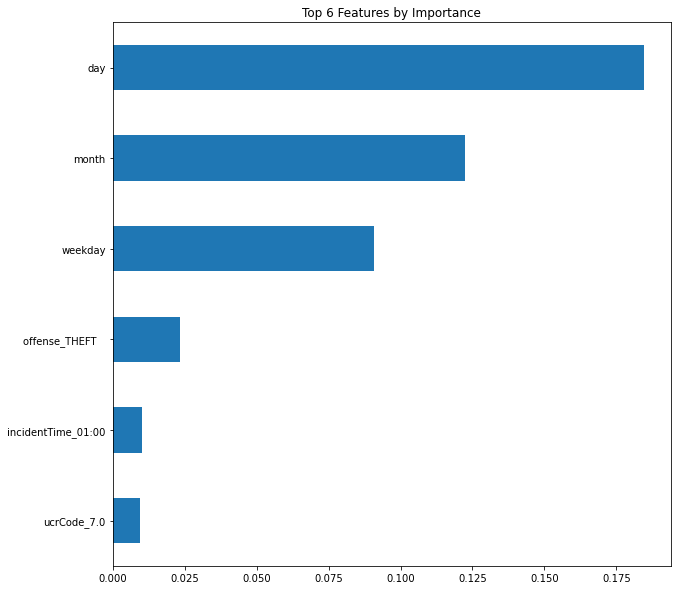

In [37]:
feature_sr = pd.Series(rf.feature_importances_, index=X.columns).\
    nlargest(6).\
    sort_values(ascending=True).\
    plot(kind='barh',title="Top 6 Features by Importance", figsize=(10, 10))

##feature_sr.plot().get_figure().savefig('../resources/rf_top_10_features.png')
plt.savefig('../resources/rf_top_6_features_fig_1.png')

In [38]:
#Get top most impactful variables to create new model.

from sklearn.ensemble import RandomForestRegressor

# New random forest with only the six most important variables
rf_most_important = RandomForestRegressor(n_estimators= 750, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('day'), feature_list.index('weekday'), feature_list.index('month'), feature_list.index('offense_THEFT'), feature_list.index('offense_BURGD'), feature_list.index('offense_TFMV')]
train_important = X_train_scaled[:, important_indices]
test_important = X_test_scaled[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, y_train)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - y_test)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
# mape = np.mean(100 * (errors / y_test))
# accuracy = 100 - mape
# print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: No     0.17
Yes    0.17
dtype: float64 degrees.


In [42]:
# Create the GridSearchCV model
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [750, 1000, 1250],
              'max_depth': [1, 10, 50],
              'criterion': ['gini', 'entropy']}
grid = GridSearchCV(rf, param_grid, verbose=3)

In [43]:
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time=  18.9s
[CV 2/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time=  19.1s
[CV 3/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time=  18.2s
[CV 4/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time=  15.3s
[CV 5/5] END ..criterion=gini, max_depth=1, n_estimators=750; total time=  13.1s
[CV 1/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time=  16.7s
[CV 2/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time=  18.0s
[CV 3/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time=  19.5s
[CV 4/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time=  20.0s
[CV 5/5] END .criterion=gini, max_depth=1, n_estimators=1000; total time=  19.7s
[CV 1/5] END .criterion=gini, max_depth=1, n_estimators=1250; total time=  22.3s
[CV 2/5] END .criterion=gini, max_depth=1, n_est

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 10, 50],
                         'n_estimators': [750, 1000, 1250]},
             verbose=3)

In [44]:
print(grid.best_params_)
print(grid.best_score_)

{'criterion': 'gini', 'max_depth': 50, 'n_estimators': 1250}
0.9019719584737549


In [47]:
predictions_grid = grid.predict(X_test_scaled)

In [48]:
print(f"Testing Data Score using Optimized Model: {grid.score(X_test_scaled, y_test)}")

Testing Data Score using Optimized Model: 0.9100231853040842
